### Base Learner 10b  - Use BW Images on a serious learner
appears we must turn on Normalize via 
    
    ('_learn_norm':    True,)
    
For this learner to run w/o breaking on accumulate. See "Why why why" section for debugging.

In [2]:
from fastai2.vision.all import *
import sys, torch
sys.path.append('..')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# %load_ext autoreload
# %autoreload 2

from modules.expbuilder import default_params, run_exp, rm_test_recorder
from modules.trainutils import piece_class_parse

train_path = Path('../../../rf-chess-data/cropped_v1/')
train_clean_path = Path('../../../rf-chess-data/cropped_v1.1/')

test_path_all = Path('../../../other-chess-data/regulation-test-2-all/')
test_path_easy = Path('../../../other-chess-data/regulation-test-2-easy/')

In [3]:
my_params = {'_train_seed':    0, 
             '_custom_crop':   'my-top-crop', 
             '_model_arch':    resnet50,
             '_train_path':    train_clean_path,
             
             '_learn_norm':    True,
             '_bw_images':     True,
            }

default_params.update(my_params)

In [4]:
set_seed(42)
train_dl, learn = run_exp(default_params, 'dummy', b_ret=True,
                         b_subcat_metrics=True)

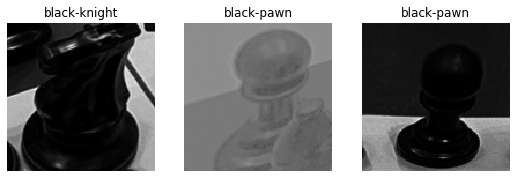

In [5]:
train_dl.show_batch(max_n=3)

In [6]:
set_seed(42)
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,subcat_color_acc,subcat_piece_acc,time
0,1.863561,0.217466,0.928571,0.998258,0.935540,00:11
1,0.964946,0.059481,0.982578,0.998258,0.984321,00:10
2,0.654998,0.067792,0.984321,0.996516,0.986063,00:10
3,0.449275,0.028077,0.994774,0.998258,0.994774,00:10
4,0.355752,0.019939,0.993031,0.998258,0.994774,00:10
5,0.263352,0.022469,0.993031,0.998258,0.994774,00:10
6,0.217106,0.014040,0.991289,0.998258,0.993031,00:10
7,0.196403,0.010945,0.993031,0.998258,0.994774,00:10
8,0.175336,0.009895,0.996516,0.998258,0.998258,00:10
9,0.174185,0.008929,0.994774,0.998258,0.996516,00:10


In [7]:
pd.DataFrame(learn.cbs[3].values)

,0,1,2,3
0,1.884496,0.473684,0.925439,0.517544
1,1.623920,0.530702,0.947368,0.570175
2,1.630815,0.583333,0.947368,0.631579
3,1.226689,0.675439,0.964912,0.710526
4,1.190647,0.679825,0.969298,0.719298
5,0.931429,0.710526,0.956140,0.750000
6,1.125607,0.679825,0.964912,0.710526
7,1.087352,0.675439,0.969298,0.692982
8,1.021131,0.679825,0.956140,0.710526
9,0.975116,0.697368,0.973684,0.719298


In [8]:
set_seed(42)
learn.fine_tune(20)

epoch,train_loss,valid_loss,accuracy,subcat_color_acc,subcat_piece_acc,time
0,0.255247,0.013153,0.996516,1.000000,0.996516,00:10


epoch,train_loss,valid_loss,accuracy,subcat_color_acc,subcat_piece_acc,time
0,0.235219,0.007127,0.998258,1.000000,0.998258,00:14
1,0.198884,0.014062,0.996516,0.998258,0.996516,00:14
2,0.186252,0.003383,0.998258,1.000000,0.998258,00:14
3,0.183569,0.023479,0.994774,1.000000,1.000000,00:14
4,0.177772,0.004359,1.000000,1.000000,1.000000,00:14
5,0.196277,0.003915,0.998258,0.998258,0.998258,00:14
6,0.206478,0.016348,0.996516,1.000000,0.996516,00:14
7,0.157257,0.001055,1.000000,1.000000,1.000000,00:14
8,0.141205,0.000231,1.000000,1.000000,1.000000,00:14
9,0.092742,0.000273,1.000000,1.000000,1.000000,00:14


In [11]:
pd.DataFrame(learn.cbs[3].values).iloc[-22:,:]

,0,1,2,3
10,1.670140,0.653509,0.982456,0.692982
11,1.127345,0.679825,0.982456,0.701754
12,0.856969,0.767544,0.982456,0.798246
13,0.723092,0.767544,0.986842,0.789474
14,1.321506,0.697368,0.986842,0.745614
15,0.869536,0.771930,1.000000,0.780702
16,0.748737,0.789474,0.978070,0.811404
17,0.911934,0.771930,0.951754,0.820175
18,0.860064,0.745614,0.978070,0.767544
19,0.628734,0.793860,0.986842,0.802632


### Interpret

              precision    recall  f1-score   support

black-bishop       0.94      0.89      0.91        18
  black-king       1.00      0.79      0.88        19
black-knight       0.62      0.95      0.75        19
  black-pawn       0.95      0.95      0.95        19
 black-queen       0.92      0.60      0.73        20
  black-rook       0.85      0.89      0.87        19
white-bishop       0.93      0.68      0.79        19
  white-king       1.00      0.84      0.91        19
white-knight       0.64      0.95      0.77        19
  white-pawn       0.70      1.00      0.83        19
 white-queen       1.00      0.53      0.69        19
  white-rook       0.80      0.84      0.82        19

    accuracy                           0.82       228
   macro avg       0.86      0.83      0.82       228
weighted avg       0.86      0.82      0.82       228



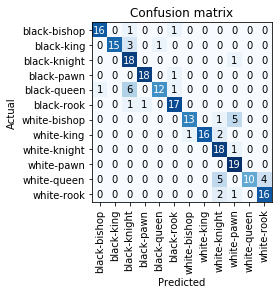

In [12]:
easy_test_dl = learn.dls.test_dl(get_image_files(test_path_easy), 
                                 with_labels=True)

interp = ClassificationInterpretation.from_learner(learn, 
                                                  dl = easy_test_dl)

interp.print_classification_report()

interp.plot_confusion_matrix()

### Why why why
appears once we successfully run `learner2.fit_onc_cycle(1)` we can go back and run `learn.fit_one_cycle(1)` and it will work.

 - Appears to do with `normalize` step.
 - This doesn't follow expected isolated behavior.

In [6]:
from modules.learnutils import learner_add_testset_2, TestSetRecorder
from modules.trainutils import subcat_color_acc, subcat_piece_acc

In [24]:
learn_metrics = [accuracy, subcat_color_acc, subcat_piece_acc]
learn_metrics = accuracy

In [25]:
train_dl.one_batch()[0].shape

torch.Size([32, 1, 128, 128])

In [26]:
learn2 = cnn_learner(train_dl, resnet50, metrics=learn_metrics,
                    normalize=True)

# learn2 = cnn_learner(train_dl, resnet50, metrics=accuracy,
#                     normalize=True)

In [27]:
# learn2.fit_one_cycle(1)

In [28]:
learner_add_testset_2(learn2, test_path_easy, b_cuda=True)

In [29]:
# len(learn2.dls[0])

In [30]:
# learn2.fit_one_cycle(1)

In [31]:
learn2.add_cb(TestSetRecorder(b_logger=False))

In [32]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.173137,0.087519,0.963415,00:10


##### Save

In [13]:
old_path = learn.path
learn.path = Path('../models')
learn.export('base-learner-10b.pkl')
learn.path = old_path

AttributeError: Can't pickle local object 'run_exp.<locals>.my_piece_class_parse'

In [ ]:
old_path

In [ ]:
len(easy_test_dl.items)

In [ ]:
162/12